<img src="./logo_UTN.svg" align="right" width="150" />

#### Procesamiento Digital de Señales
# TS8: Ancho de Banda de ECG
#### Eloy Silva

### Configuración e inicio de la simulación

In [14]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io as sio

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (13,7)

import warnings
warnings.filterwarnings('ignore')

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

### Lectura de Electrocardiograma (ECG). Gráfico de ECG completo, primeros 10 segundos y realizaciones de todos los latidos.

Text(0.5, 1.0, 'Realizaciones de latidos en una ventana')

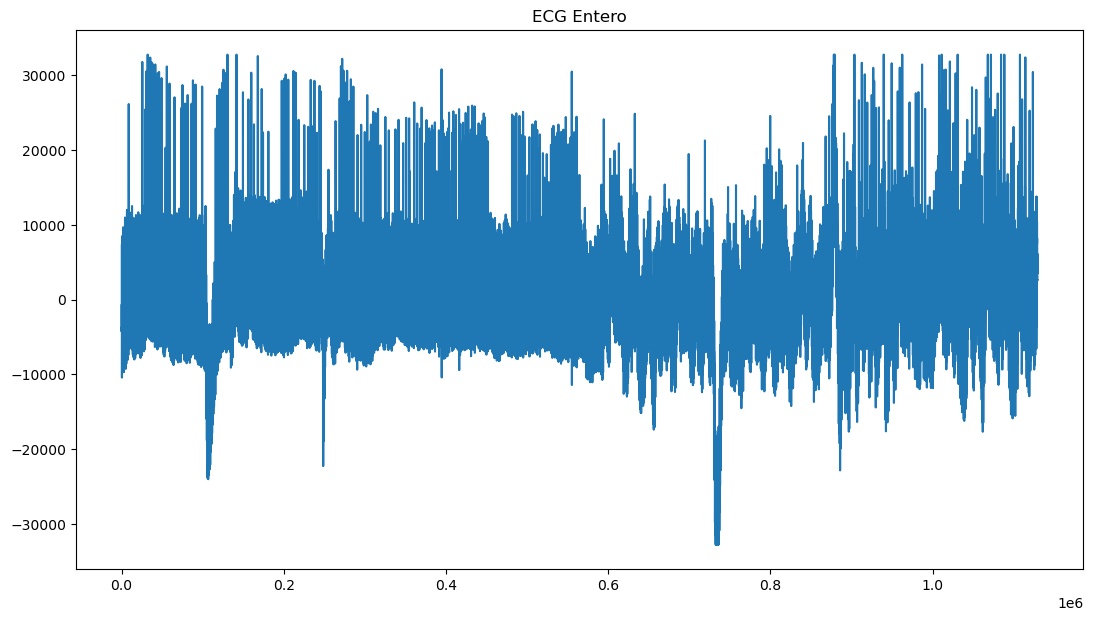

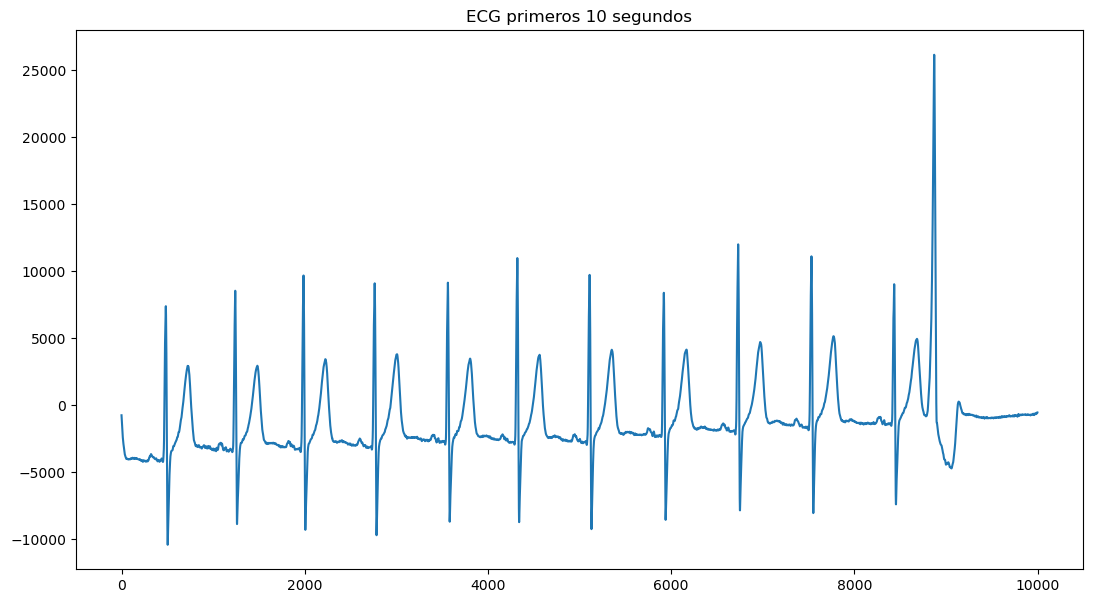

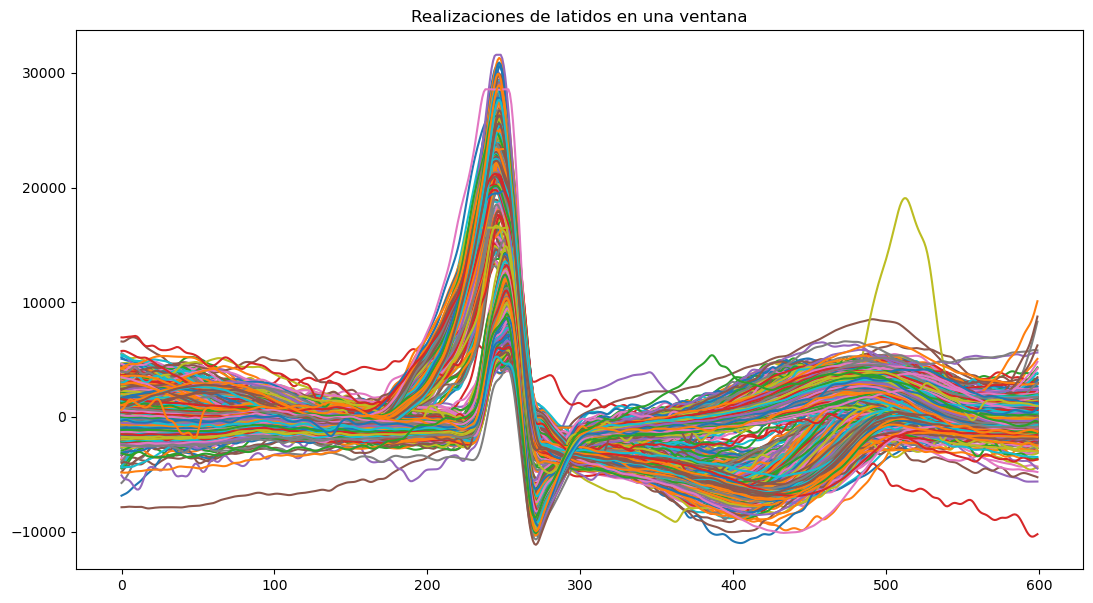

In [15]:
fs = 1000 # Hz
mat_struct = sio.loadmat('ECG_TP4.mat')

ecg_full = vertical_flaten(mat_struct['ecg_lead'])
N_full = len(ecg_full)
ecg_trim = ecg_full[0:10000]                    #Primeros 10 segundos
N_trim = len(ecg_trim)

qrs_detections = mat_struct['qrs_detections']
qrs_pattern = mat_struct['qrs_pattern1']

N_qrs = 600
max_hb = max(abs(ecg_full))
qrs_hb = np.zeros((N_qrs, len(qrs_detections)))
for i in range(len(qrs_detections)):
    hb = int(qrs_detections[i])
    qrs_hb[:, i] = (ecg_full[hb-250:hb+350].squeeze()-np.mean(ecg_full[hb-250:hb+350]))

plt.figure()
plt.plot(ecg_full)
plt.title('ECG Entero')
plt.figure()
plt.plot(ecg_trim)
plt.title('ECG primeros 10 segundos')
plt.figure()
plt.plot(qrs_hb)
plt.title('Realizaciones de latidos en una ventana')

### Cálculo de espectros mediante Welch para los tres casos. Estimación de ancho de banda a partir del promedio de todas las realizaciones de latidos para definición de plantilla.

Ancho de banda a al 99.0% del promedio de realizaciones: 33.333333333333336


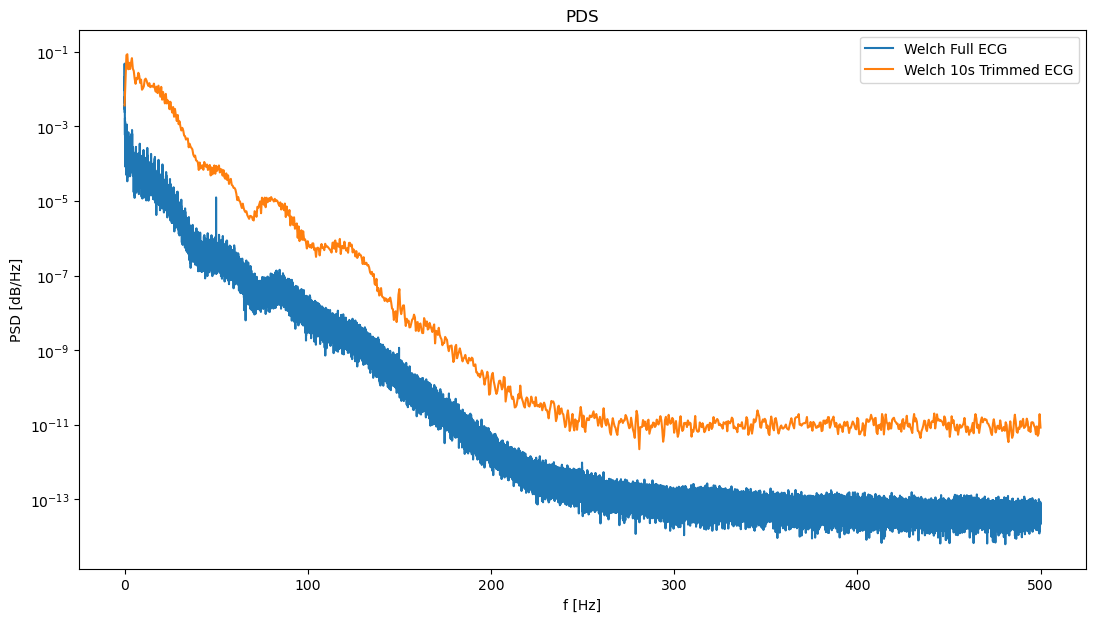

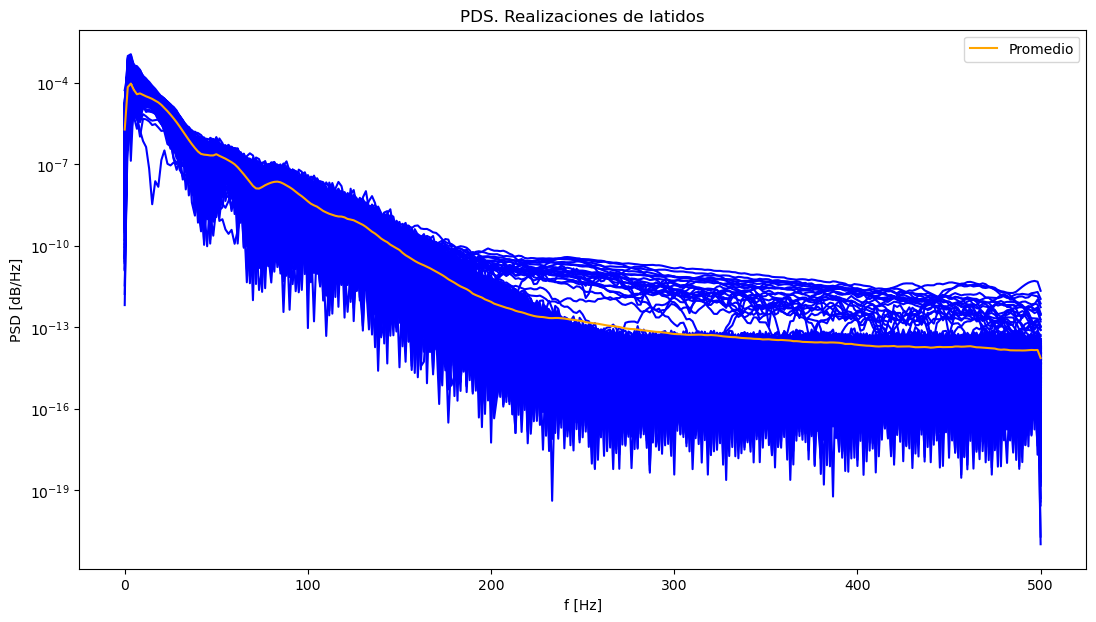

In [23]:
freq_full, welch_full = sp.signal.welch(ecg_full, fs=fs, nperseg=N_full/5, axis=0)
freq_trim, welch_trim = sp.signal.welch(ecg_trim, fs=fs, nperseg=N_trim/5, axis=0)
freq_qrs, welch_qrs = sp.signal.welch(qrs_hb, fs=fs, nperseg=N_qrs, axis=0)

welch_full = welch_full/np.sum(welch_full)
welch_trim = welch_trim/np.sum(welch_trim)
welch_qrs = welch_qrs/np.sum(welch_qrs)

plt.figure();
plt.semilogy(freq_full, welch_full, label='Welch Full ECG')
plt.semilogy(freq_trim, welch_trim, label='Welch 10s Trimmed ECG')
plt.title('PDS')
plt.xlabel('f [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.legend()

qrs_mean = np.mean(welch_qrs, axis=1)

plt.figure();
plt.semilogy(freq_qrs, welch_qrs, color='blue')
plt.semilogy(freq_qrs, qrs_mean, color='orange', label='Promedio')
plt.title('PDS. Realizaciones de latidos')
plt.xlabel('f [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.legend()

qrs_mean = qrs_mean/np.sum(qrs_mean)
Paccum_welch = np.cumsum(qrs_mean)
thresh = 0.99
index = np.where(Paccum_welch >= thresh)[0][0]
Bw = freq_qrs[index]
print('Ancho de banda a al ' + str(thresh*100) + '% del promedio de realizaciones: ' + str(Bw))

### Gráfico de los distintos espectros hasta los 50Hz.

(0.0, 50.0)

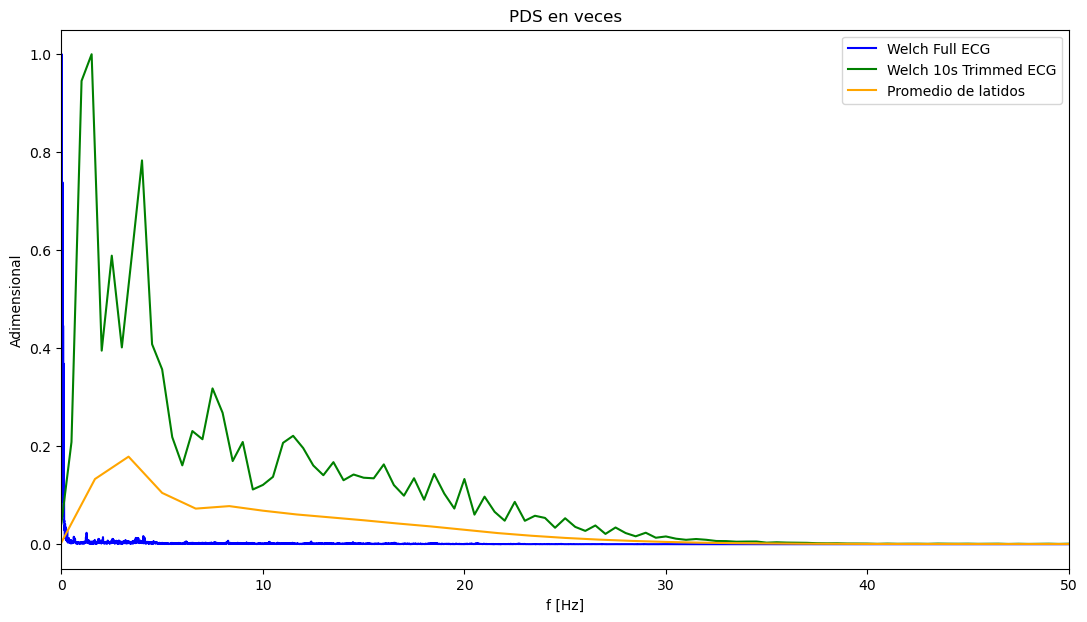

In [20]:
welch_full = welch_full/np.max(welch_full)
welch_trim = welch_trim/np.max(welch_trim)
welch_qrs = welch_qrs/np.max(welch_qrs)

plt.figure();
plt.plot(freq_full, welch_full, color='blue', label='Welch Full ECG')
plt.plot(freq_trim, welch_trim, color='green', label='Welch 10s Trimmed ECG')
plt.plot(freq_qrs, qrs_mean, color='orange', label='Promedio de latidos')
plt.title('PDS en veces')
plt.xlabel('f [Hz]')
plt.ylabel('Adimensional')
plt.legend()
plt.xlim(0, 50)

#### Observamos en este gráfico que tanto el espectro de los primeros 10 segundos como el promedio de las realizaciones de latidos poseen contenido espectral hasta aproximadamente los 30Hz, indicando que a partir de allí ya no hay información útil por lo que podemos utilizar ese valor como fin de la banda de paso, y para el fin de la banda de detenida se usa 50Hz para dejarle un margen al filtro para realizar la transición.

### Gráfico de los distintos espectros hasta 1Hz.

(0.0, 1.0)

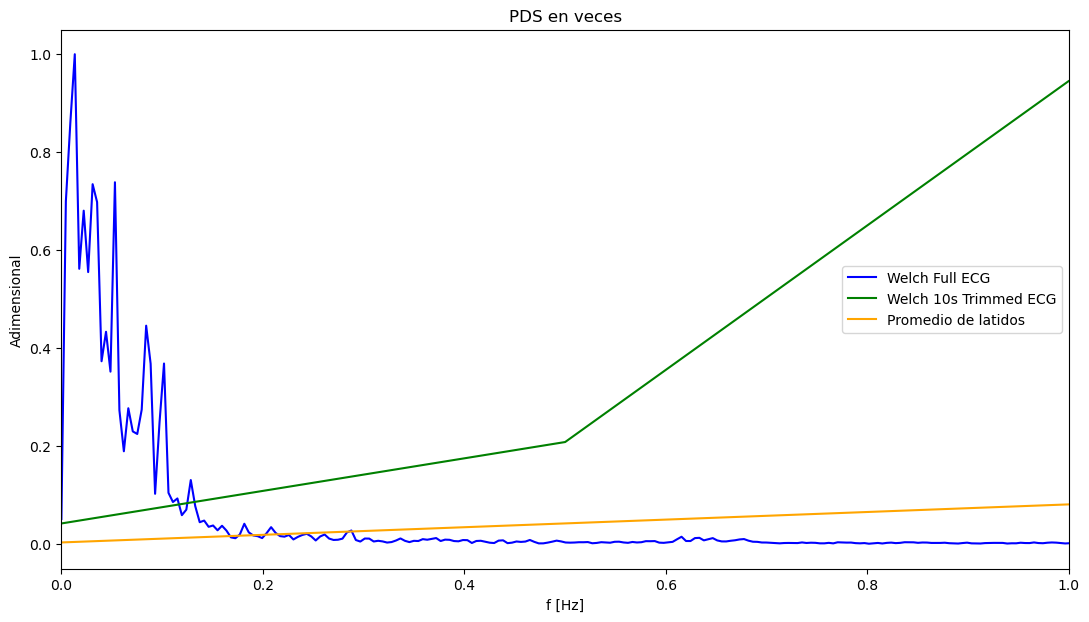

In [21]:
plt.figure();
plt.plot(freq_full, welch_full, color='blue', label='Welch Full ECG')
plt.plot(freq_trim, welch_trim, color='green', label='Welch 10s Trimmed ECG')
plt.plot(freq_qrs, qrs_mean, color='orange', label='Promedio de latidos')
plt.title('PDS en veces')
plt.xlabel('f [Hz]')
plt.ylabel('Adimensional')
plt.legend()
plt.xlim(0, 1)

#### Aquí se aprecia que el espectro del ECG completo posee la mayor cantidad de energía por debajo de los 0.1Hz, lo cual se conrresponde con interferencias y no la señal de interés por lo que deben ser filtradas. Es por esto que se coloca el inicio de la banda de paso en 1Hz en vez de 0Hz.

### A partir del ancho de banda estimado y de los análisis de los dos gráficos anteriores, establecemos la plantilla del filtro a diseñar para preservar la mayor cantidad de información en baja frecuencia, eliminando el ruido de alta frecuencia y las alteraciones de muy baja frecuencia.
#### fs1 (comienzo de la banda de detenida 1): 0Hz
#### fc0 (comienzo de la banda de paso): 1Hz
#### fc1 (fin de la banda de paso): 30Hz
#### fs0 (fin de la banda de detenida 0): 50Hz